# Different Expression Analysis

An important task of bulk rna-seq analysis is the different expression , which we can perform with omicverse. For different expression analysis, ov change the `gene_id` to `gene_name` of matrix first. When our dataset existed the batch effect, we can use the SizeFactors of DEseq2 to normalize it, and use `t-test` of `wilcoxon` to calculate the p-value of genes. Here we demonstrate this pipeline with a matrix from `featureCounts`. The same pipeline would generally be used to analyze any collection of RNA-seq tasks. 

Colab_Reproducibility：https://colab.research.google.com/drive/1q5lDfJepbtvNtc1TKz-h4wGUifTZ3i0_?usp=sharing

In [1]:
import omicverse as ov
import scanpy as sc
import matplotlib.pyplot as plt

ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.11, Tutorials: https://omicverse.readthedocs.io/


## Geneset Download

When we need to convert a gene id, we need to prepare a mapping pair file. Here we have pre-processed 6 genome gtf files and generated mapping pairs including `T2T-CHM13`, `GRCh38`, `GRCh37`, `GRCm39`, `danRer7`, and `danRer11`. If you need to convert other id_mapping, you can generate your own mapping using gtf Place the files in the `genesets` directory.

In [2]:
ov.utils.download_geneid_annotation_pair()

......Geneid Annotation Pair download start: pair_GRCm39
......Loading dataset from genesets/pair_GRCm39.tsv
......Geneid Annotation Pair download start: pair_T2TCHM13
......Loading dataset from genesets/pair_T2TCHM13.tsv
......Geneid Annotation Pair download start: pair_GRCh38
......Loading dataset from genesets/pair_GRCh38.tsv
......Geneid Annotation Pair download start: pair_GRCh37
......Loading dataset from genesets/pair_GRCh37.tsv
......Geneid Annotation Pair download start: pair_danRer11
......Loading dataset from genesets/pair_danRer11.tsv
......Geneid Annotation Pair download start: pair_danRer7
......Loading dataset from genesets/pair_danRer7.tsv
......Geneid Annotation Pair download finished!


Note that this dataset has not been processed in any way and is only exported by `featureCounts`, and Sequence alignment was performed from the genome file of CRCm39

sample data can be download from: https://raw.githubusercontent.com/Starlitnightly/omicverse/master/sample/counts.txt

In [3]:
data=ov.pd.read_csv('https://raw.githubusercontent.com/Starlitnightly/omicverse/master/sample/counts.txt',index_col=0,sep='\t',header=1)
#data=ov.read('data/counts.txt',index_col=0,header=1)
#replace the columns `.bam` to `` 
data.columns=[i.split('/')[-1].replace('.bam','') for i in data.columns]
data.head()

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
Geneid,,,,,,,,,,,,
ENSMUSG00000102628,0,0,0,0,5,0,0,0,0,0,0,9
ENSMUSG00000100595,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000097426,5,0,0,0,0,0,0,1,0,0,0,0
ENSMUSG00000104478,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104385,0,0,0,0,0,0,0,0,0,0,0,0


## ID mapping

We performed the gene_id mapping by the mapping pair file `GRCm39` downloaded before.

In [4]:
data=ov.bulk.Matrix_ID_mapping(data,'genesets/pair_GRCm39.tsv')
data.head()

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
Gm37732,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00002075679,0,0,0,0,0,0,0,0,0,0,0,0
Mir485,0,0,0,0,0,0,0,0,0,0,0,0
Gm45619,6,1,6,3,3,9,4,2,22,3,0,17
Gm25097,0,0,0,0,0,0,0,0,0,0,0,0


## Different expression analysis with ov

We can do differential expression analysis very simply by ov, simply by providing an expression matrix. To run DEG, we simply need to:

- Read the raw count by featureCount or any other qualify methods.
- Create an ov DEseq object.

In [5]:
dds=ov.bulk.pyDEG(data)

We notes that the gene_name mapping before exist some duplicates, we will process the duplicate indexes to retain only the highest expressed genes

In [6]:
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

... drop_duplicates_index success


We also need to remove the batch effect of the expression matrix, `estimateSizeFactors` of DEseq2 to be used to normalize our matrix

In [7]:
dds.normalize()
print('... estimateSizeFactors and normalize success')

... estimateSizeFactors and normalize success


Now we can calculate the different expression gene from matrix, we need to input the treatment and control groups

### ttest

In [17]:
treatment_groups=['4-3','4-4']
control_groups=['1--1','1--2']
result_ttest=dds.deg_analysis(treatment_groups,control_groups,method='ttest')
result_ttest.sort_values('qvalue').head()

⚙️ You are using ttest method for differential expression analysis.
⏰ Start to calculate qvalue...
✅ Differential expression analysis completed.


,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
gene_id,,,,,,,,,,,,
Uqcrh,0.000005,0.000009,1.340669,2847.780642,2485.934617,11.279573,0.422953,0.422953,0.134067,5.341574,5.050298,sig
Tdrd7,0.000016,0.000031,0.819932,570.613422,519.217650,9.020196,-0.286423,0.286423,0.081993,4.796963,4.505703,sig
Glo1-ps,0.000016,0.000032,0.538839,1718.087949,1321.875745,10.368371,-0.892074,0.892074,0.053884,4.792256,4.501011,sig
Kmt2a,0.000023,0.000045,1.203046,1337.209316,1224.344556,10.257794,0.266692,0.266692,0.120305,4.638583,4.347354,sig
5730522E02Rik,0.000028,0.000054,34.728018,7.971628,3.985814,1.994874,5.118028,5.118028,3.472802,4.560393,4.270316,sig


### (optional) edgeR with python

This module is a partial port in Python of the R Bioconductor [edgeR package](https://bioconductor.org/packages/release/bioc/html/edgeR.html).

In [14]:
result_edgepy=dds.deg_analysis(treatment_groups,control_groups,method='edgepy')
result_edgepy.sort_values('qvalue').head()

⚙️ You are using edgepy method for differential expression analysis.
⏰ Start to create DGEList...
⏰ Start to calculate qvalue...
✅ Differential expression analysis completed.


,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
gene_id,,,,,,,,,,,,
Krtap9-5,2.904895e-46,1.583284e-41,0.000473,1547.775572,774.135593,9.596442,-11.046357,11.046357,1.104636,45.536870,40.800441,sig
Krtap31-2,2.824260e-36,7.696673e-32,0.005276,2119.945065,1065.447800,10.057244,-7.566236,7.566236,0.756624,35.549095,31.113697,sig
Krtap19-4,7.394568e-34,1.343445e-29,0.007051,1801.648929,907.058833,9.825052,-7.147957,7.147957,0.714796,33.131087,28.871780,sig
Gm4553,2.906425e-33,3.960294e-29,0.007580,1747.474564,880.242980,9.781758,-7.043576,7.043576,0.704358,32.536641,28.402273,sig
Gm10153,1.665008e-29,1.512493e-25,0.000884,267.271967,133.635984,7.062165,-10.144441,10.144441,1.014444,28.778584,24.820307,sig


## (optional) limma

This module is a partial port in Python of the R Bioconductor [limma package](https://bioconductor.org/packages/release/bioc/html/limma.html).

In [10]:
result_limma=dds.deg_analysis(treatment_groups,control_groups,method='limma')
result_limma.sort_values('qvalue').head()

[WARNING] More than half of residual variances are exactly zero: eBayes unreliable


⚙️ You are using limma method for differential expression analysis.
⏰ Start to create DGEList...
⏰ Start to adjust pvalue...
✅ Differential expression analysis completed.


,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,sig,-log(pvalue),-log(qvalue),F,t
gene_id,,,,,,,,,,,,,,
Gm5853,0.000011,0.007723,5.216002,0.996454,0.498227,-1.005126,2.382945,2.382945,0.238294,sig,4.951007,2.112206,31871.910979,178.527060
Gm14409,0.000011,0.007723,5.216002,0.996454,0.498227,-1.005126,2.382945,2.382945,0.238294,sig,4.951007,2.112206,31871.910979,178.527060
Tdrd7,0.000005,0.007723,0.819932,570.613422,519.217650,9.020196,-0.286423,0.286423,0.028642,sig,5.330687,2.112206,69832.580356,-264.258548
Myl10,0.000009,0.007723,13.648007,2.989361,1.494680,0.579837,3.770618,3.770618,0.377062,sig,5.052672,2.112206,39320.908935,198.295005
5730522E02Rik,0.000009,0.007723,34.728018,7.971628,3.985814,1.994874,5.118028,5.118028,0.511803,sig,5.064980,2.112206,40333.534198,200.832105


One important thing is that we do not filter out low expression genes when processing DEGs, and in future versions I will consider building in the corresponding processing.

In [11]:
print(dds.result.shape)
dds.result=dds.result.loc[dds.result['log2(BaseMean)']>1]
print(dds.result.shape)

(54504, 14)
(21279, 14)


We also need to set the threshold of Foldchange, we prepare a method named `foldchange_set` to finish. This function automatically calculates the appropriate threshold based on the log2FC distribution, but you can also enter it manually.

In [19]:
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=6)

... Fold change threshold: 1.569942639522294


## Visualize the DEG result and specific genes

To visualize the DEG result, we use `plot_volcano` to do it. This fuction can visualize the gene interested or high different expression genes. There are some parameters you need to input:

- title: The title of volcano
- figsize: The size of figure
- plot_genes: The genes you interested
- plot_genes_num: If you don't have interested genes, you can auto plot it.

<AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

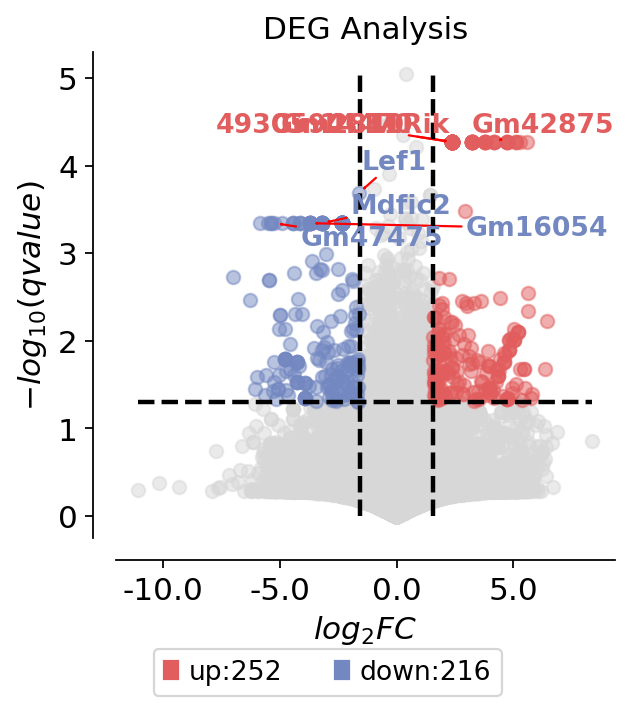

In [20]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

To visualize the specific genes, we only need to use the `dds.plot_boxplot` function to finish it.

(<Figure size 400x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

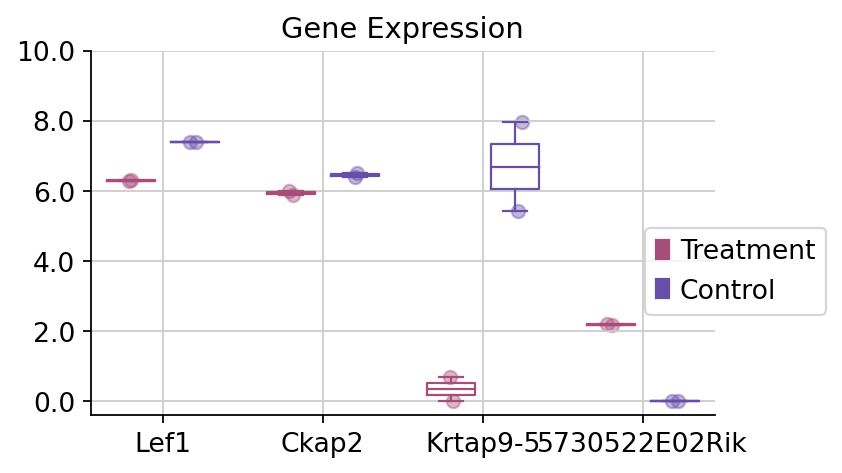

In [29]:
dds.plot_boxplot(genes=['Ckap2','Lef1','Krtap9-5','5730522E02Rik'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(5,3),fontsize=12,
                 legend_bbox=(1.2,0.55))

[Text(0, 5.800000000000001, '5.8'),
 Text(0, 6.000000000000001, '6.0'),
 Text(0, 6.200000000000001, '6.2'),
 Text(0, 6.4, '6.4'),
 Text(0, 6.6000000000000005, '6.6')]

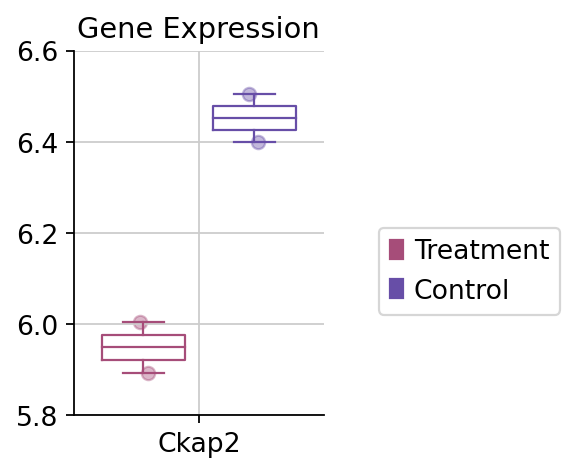

In [50]:
fig,ax=dds.plot_boxplot(genes=['Ckap2'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))
#convert the ytickbels
ax.set_yticklabels([round(float(i.get_text()),2) for i in ax.get_yticklabels()])

## Pathway enrichment analysis by ov

Here we use the `gseapy` package, which included the GSEA analysis and Enrichment. We have optimised the output of the package and given some better looking graph drawing functions

Similarly, we need to download the pathway/genesets first. Five genesets we prepare previously, you can use `ov.utils.download_pathway_database()` to download automatically. Besides, you can download the pathway you interested from enrichr: https://maayanlab.cloud/Enrichr/#libraries

In [37]:
ov.utils.download_pathway_database()

......Pathway Geneset download start: GO_Biological_Process_2021
......Loading dataset from genesets/GO_Biological_Process_2021.txt
......Pathway Geneset download start: GO_Cellular_Component_2021
......Loading dataset from genesets/GO_Cellular_Component_2021.txt
......Pathway Geneset download start: GO_Molecular_Function_2021
......Loading dataset from genesets/GO_Molecular_Function_2021.txt
......Pathway Geneset download start: WikiPathway_2021_Human
......Loading dataset from genesets/WikiPathway_2021_Human.txt
......Pathway Geneset download start: WikiPathways_2019_Mouse
......Loading dataset from genesets/WikiPathways_2019_Mouse.txt
......Pathway Geneset download start: Reactome_2022
......Loading dataset from genesets/Reactome_2022.txt
......Pathway Geneset download finished!


In [14]:
pathway_dict=ov.utils.geneset_prepare('genesets/WikiPathways_2019_Mouse.txt',organism='Mouse')

Note that the `pvalue_type` we set to `auto`, this is because when the genesets we enrichment if too small, use the `adjusted pvalue` we can't get the correct result. So you can set `adjust` or `raw` to get the significant geneset.

If you didn't have internet, please set `background` to all genes expressed in rna-seq,like:

```python
enr=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                background=dds.result.index.tolist(),
                                organism='mouse')
```

In [15]:
deg_genes=dds.result.loc[dds.result['sig']!='normal'].index.tolist()
enr=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='mouse')

To visualize the enrichment, we use `geneset_plot` to finish it

<AxesSubplot: title={'center': 'Wiki Pathway enrichment'}, xlabel='Fractions of genes'>

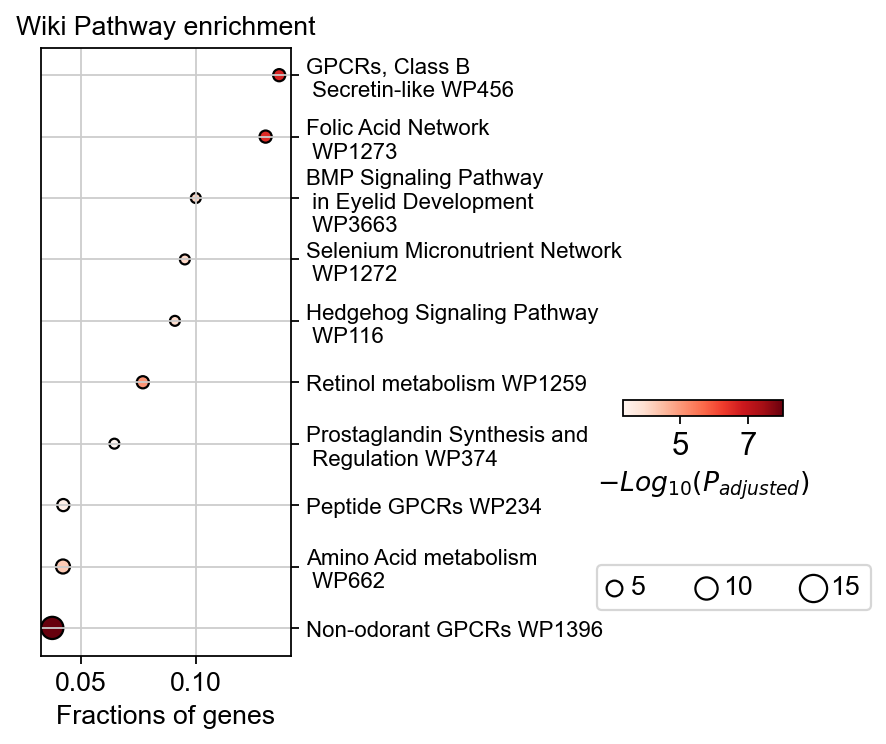

In [21]:
ov.bulk.geneset_plot(enr,figsize=(2,5),fig_title='Wiki Pathway enrichment',
                    cax_loc=[2, 0.45, 0.5, 0.02],
                    bbox_to_anchor_used=(-0.25, -13),node_diameter=10,
                     custom_ticks=[5,7],text_knock=3,
                    cmap='Reds')

## Multi pathway enrichment

In addition to pathway enrichment for a single database, OmicVerse supports enriching and visualizing multiple pathways at the same time, which is implemented using [`pyComplexHeatmap`](https://dingwb.github.io/PyComplexHeatmap/build/html/notebooks/gene_enrichment_analysis.html), and Citetation is welcome!

In [22]:
pathway_dict=ov.utils.geneset_prepare('genesets/GO_Biological_Process_2023.txt',organism='Mouse')
enr_go_bp=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='mouse')
pathway_dict=ov.utils.geneset_prepare('genesets/GO_Molecular_Function_2023.txt',organism='Mouse')
enr_go_mf=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='mouse')
pathway_dict=ov.utils.geneset_prepare('genesets/GO_Cellular_Component_2023.txt',organism='Mouse')
enr_go_cc=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='mouse')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 106.70147475919528
Plotting legends..
Estimated legend width: 9.879166666666666 mm


<Axes: ylabel='$−Log_{10}(P_{adjusted})$'>

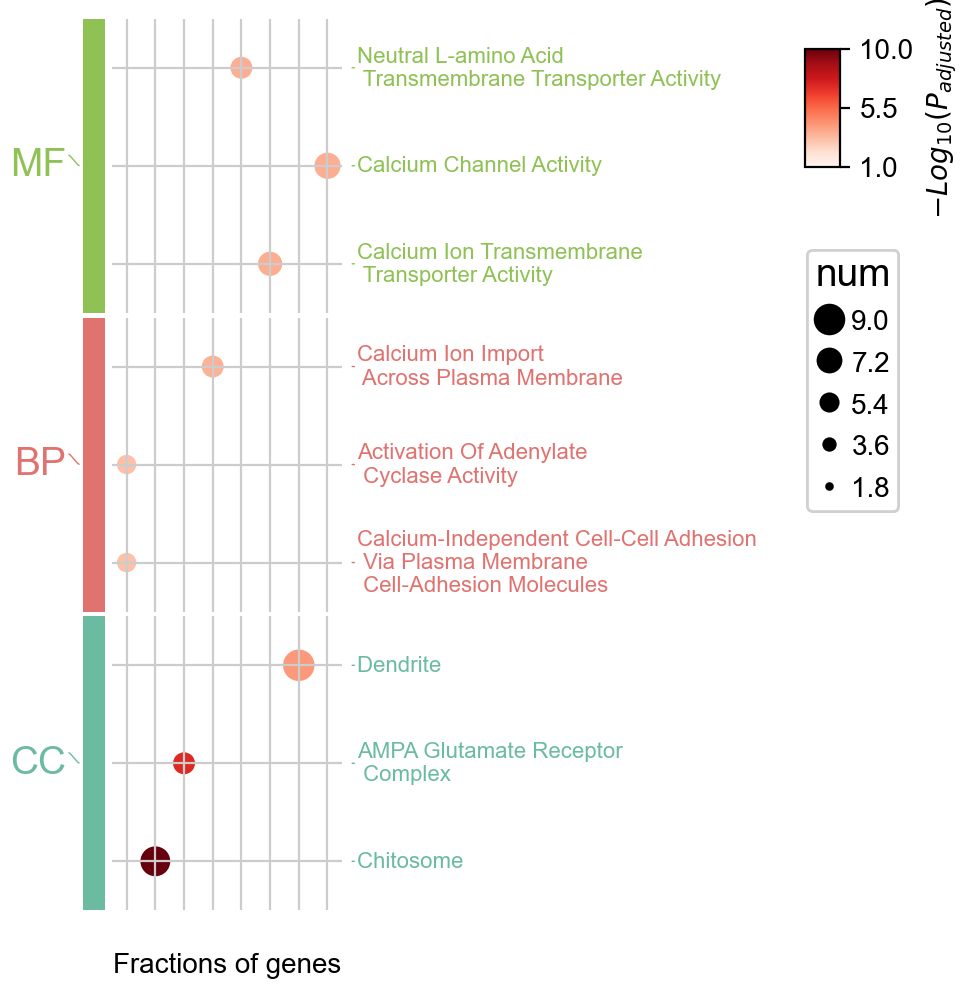

In [167]:
enr_dict={'BP':enr_go_bp,
         'MF':enr_go_mf,
         'CC':enr_go_cc}
colors_dict={
    'BP':ov.pl.red_color[1],
    'MF':ov.pl.green_color[1],
    'CC':ov.pl.blue_color[1],
}
                
ov.bulk.geneset_plot_multi(enr_dict,colors_dict,num=3,
                   figsize=(2,5),
                   text_knock=3,fontsize=8,
                    cmap='Reds'
                  )